<a href="https://colab.research.google.com/github/sipocz/Colab/blob/main/timeseries_prediction_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Napfolt tevékenység előrejelzése

Telekommunikációs cégünk új szolgáltatása fokozott forgalomterhelést okoz hálozatunkon, így új műholdas átviteli megoldásokat is be kell vonnunk a forgalom kiszolgálásához. A műszaki csoport vélemény szerint az "űr időjárás" alapvetően befolyásolhatja a műholdas kommunikációs megoldásainkat, így fel kell mérnünk a kockázatokat. Az űr időjárás egyik fontos tényezője a naptevékenység, így annak pontos előrejelzése segítséget nyújthat az üzemeltetés során. Az űridőjárás egyik meghatározó eleme a napfolt tevékenység, így az elsődleges feladat annak modellezése. 

Bővebb információ magáról a jelenségről [itt](https://en.wikipedia.org/wiki/Sunspot#Application) található.

## Elsődleges adatforrás

A modellezés során a [Sunspot Index and Long-term Solar Observations](http://www.sidc.be/silso/datafiles) adataiból indulunnk ki.

Havi adatok [itt](http://www.sidc.be/silso/INFO/snmtotcsv.php)

Kapcsolódó adatleíró [itt](http://www.sidc.be/silso/infosnmtot)

Napi adatok [itt](http://www.sidc.be/silso/INFO/sndtotcsv.php)

Kapcsolódó adatleíró [itt](http://www.sidc.be/silso/infosndtot)


## Havi modellezés

### Feladat 1:

Töltse le, majd be a havi adatsort! 

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd


Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/My Drive/001_AI/06_AI/SN_m_tot_V2.0.csv",header=None, sep=";")
df.tail()

,0,1,2,3,4,5,6
3259,2020,8,2020.624,7.5,4.1,1587,1
3260,2020,9,2020.706,0.6,2.2,1244,1
3261,2020,10,2020.791,14.4,1.2,662,0
3262,2020,11,2020.873,34.0,2.9,661,0
3263,2020,12,2020.958,21.8,5.5,812,0


### Feladat 2:

Végezzen "exploratív" elemzést az adatokon, leírók és grafikonok segítségével mutassa be főbb jellemzőit!

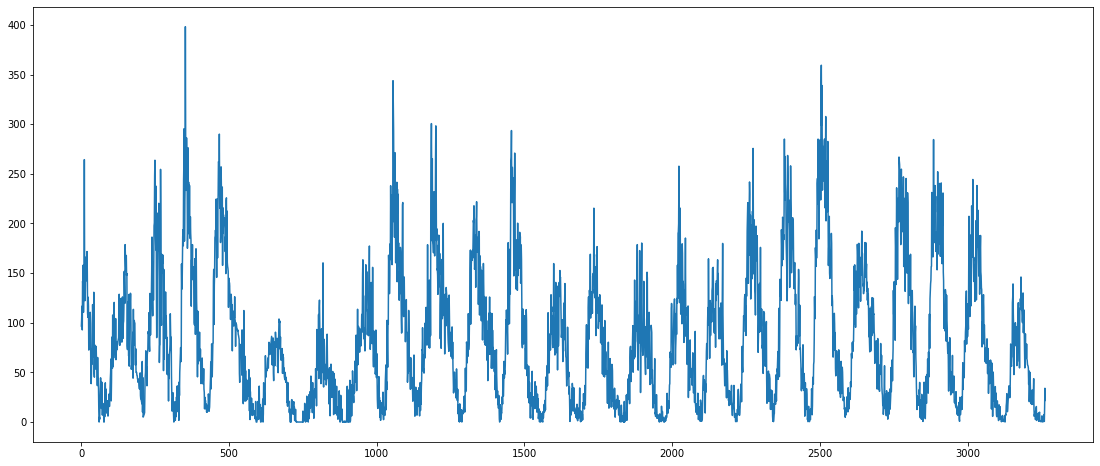

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(19, 8))

plot = df[3].plot()
plt.show()

Trend vagy Stacionárius folyamat?
"... a stacionárius folyamat (más néven szigorúan vagy erősen helyhez kötött folyamat) egy sztochasztikus folyamat, amelynek feltétel nélküli közös valószínűség-eloszlása nem változik, az időben haladva. Következésképpen az olyan paraméterek, mint az átlag és szórás idővel nem változnak."

Általában a Dickey-Fuller teszt azt a célt szolgálja, hogy megállapítsa egy folyamat stacionárius jellegét. Ha a  p  valószínűségértéke az 5% -os bizalmi érték alatt van, hajlamosak vagyunk elfogadni a folyamatot stacionáriusnak. Itt, ebben az esetben - anélkül, hogy túl nagy meglepetést okozna - arra következtethetünk, hogy a folyamat nem stacionárius.

In [6]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df[3].values)

print('p-value: %f' % result[1])

print("0.05 alatt kellene lennie")

p-value: 0.000000
0.05 alatt kellene lennie


### Feladat 3:

Foglamazzon meg modellezési kereteket, elképzeléseket az adattal kapcsolatosan! (Használt módszerek, időablak, annak mérete...?)

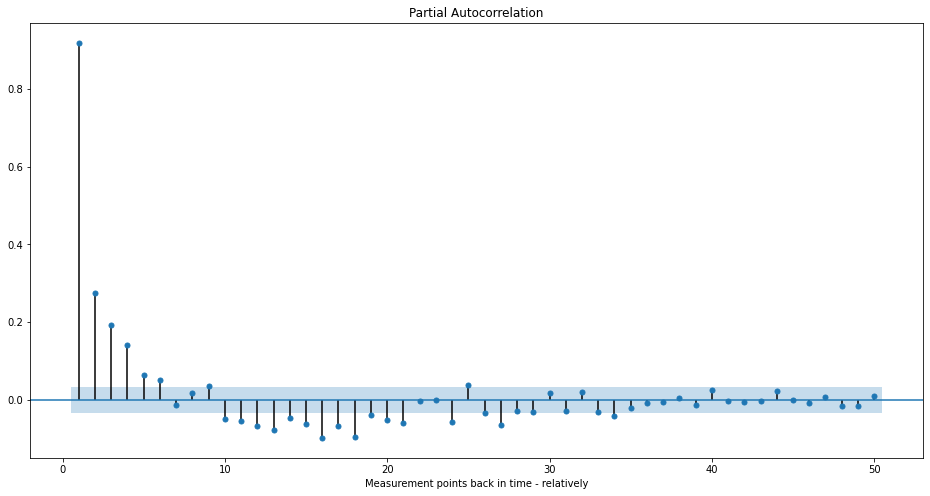

---


In [8]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, ax = plt.subplots(figsize=(16,8))

plot_pacf(df[3].values, lags=50, zero=False, ax=ax)
plt.xlabel("Measurement points back in time - relatively")

plt.show()
print("---")

In [11]:
from sklearn.model_selection import train_test_split
# !!! shuffle = False !!!
train_data, test_data = train_test_split(df, test_size=0.1, shuffle=False)

### Feladat 4:

Illesszen egyszerű lineáris modellt az adatra, értékelje annak teljesítményét, vonja le a tanulságokat!

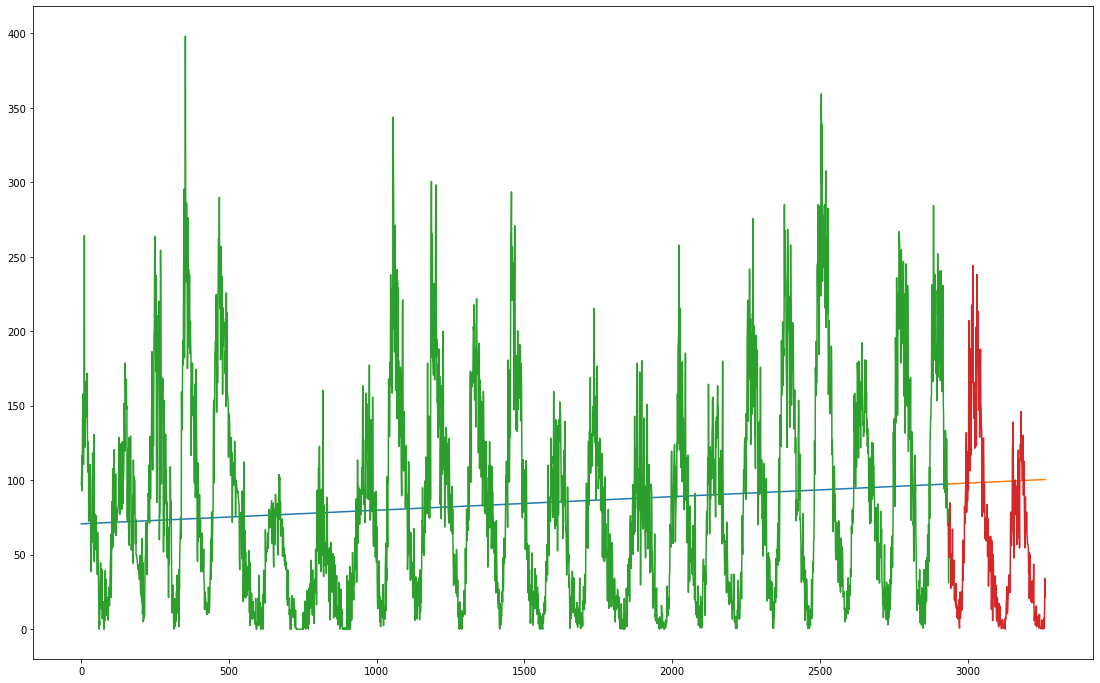

In [12]:
from sklearn.linear_model import LinearRegression

lin_model= LinearRegression()
lin_model.fit(train_data.index.astype("int64").values.reshape(-1, 1),train_data[3].values)#

train_fit = lin_model.predict(train_data.index.astype("int64").values.reshape(-1, 1))
train_fit = pd.Series(train_fit)
train_fit.index =train_data.index

prediction = lin_model.predict(test_data.index.astype("int64").values.reshape(-1, 1))
prediction = pd.Series(prediction)
prediction.index =test_data.index


fig, ax = plt.subplots(figsize=(19,12))
plt.plot(train_fit)
plt.plot(prediction)

plt.plot(train_data[3])

plt.plot(test_data[3])

plt.show()

### Feladat 5:

Használjon autoregresszív modellt az előrejelzésre, értékelje annak teljesítményét!

In [19]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

history = [x for x in list(train_data[3].values.astype("float"))]
predictions = list()

print("Előrejelzés az ARIMA-val:\n")

# Lépésről lépésre bejárjuk a tesztkészletet
# Igen, tesztkészlet. Ez minden egyes adatpontra online tanulási forgatókönyvként értelmezhető. 
for t in range(len(list(test_data[3].values.astype("float")))):
    # Modell inicializálása
    model = ARIMA(history, order=(4,2,0))
    # Kedves fejlesztők, légyszi csináljatok már egy bullshit mentes model.fit() megoldást Scikit-szerűen a stdoutre, 
    #hogy ne kelljen vesződni! Köszi! :-P 
    model_fit = model.fit(disp=0)
    # Egy időperiódus előrejelzése
    output = model_fit.forecast()
    # Összegyűjtés
    yhat = output[0]
    predictions.append(yhat)
    
    #Egy lépés előre az időben
    obs = list(test_data[3].values.astype("float"))[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))



Előrejelzés az ARIMA-val:

predicted=26.126601, expected=71.100000
predicted=59.060877, expected=48.200000
predicted=44.297141, expected=68.400000
predicted=58.474738, expected=84.900000
predicted=85.762898, expected=54.900000
predicted=68.697336, expected=47.500000
predicted=48.549842, expected=27.400000
predicted=30.532756, expected=29.800000
predicted=18.254776, expected=39.700000
predicted=22.696670, expected=50.600000
predicted=42.994658, expected=34.300000
predicted=35.403485, expected=40.500000
predicted=44.570168, expected=67.100000
predicted=68.022390, expected=29.500000
predicted=35.802190, expected=32.200000
predicted=31.031738, expected=32.600000
predicted=33.321161, expected=45.800000
predicted=39.823584, expected=46.300000
predicted=39.059284, expected=21.600000
predicted=28.195852, expected=19.400000
predicted=20.371921, expected=22.500000
predicted=18.696830, expected=20.400000
predicted=11.918381, expected=18.200000
predicted=11.268706, expected=15.700000
predicted=15.


Mean abs error: 15.427119868341716
Explained variance: 0.8452936605871474


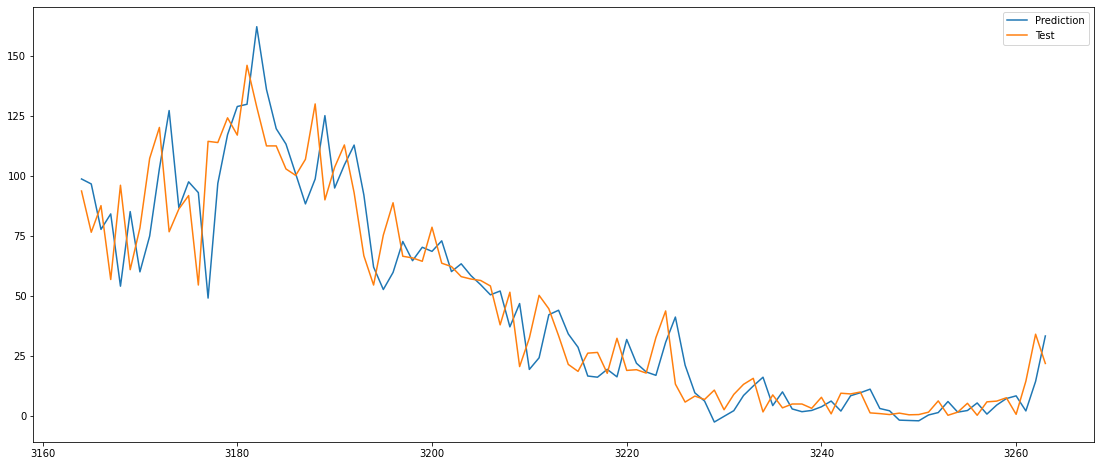

In [26]:
from sklearn.metrics import mean_absolute_error, explained_variance_score
# Készítsünk valamilyen hibaelemzést
    
errors = np.array(test_data[3].values)-np.array(predictions)

print()
print("Mean abs error:",mean_absolute_error(test_data[3].values,predictions))
print("Explained variance:",explained_variance_score(test_data[3].values,predictions))

predictions = pd.Series(predictions)
predictions.index =test_data.index    

fig, ax = plt.subplots(figsize=(19,8))
plt.plot(predictions[-100:], label="Prediction")

#plt.plot(train_data[3][-100:], label="Train")

plt.plot(test_data[3][-100:], label="Test")
plt.legend()
plt.show()

### Feladat 6:

Alkalmazzon tetszőleges összetettebb modellezési módszert, maximalizálja a prediktív teljesítményt!

In [9]:
sunspot=[]
for 


### Feladat 7:

Válassza ki a legjobbnak ítélt modellezési módot, írja le esetleges előnyeit / hátrányait!

In [60]:
def reshape(l):
    o=[]
    for i in l:
        o.append([i])
    return(o) 

In [61]:
print(reshape([1,2,3]))

[[1], [2], [3]]


In [121]:
sample=30
X_train=[]
y_train=[]
X_test=[]
y_test=[]

for t in range(len(list(train_data[3].values.astype("float")))-sample):
    a=list(train_data[3][t:t+sample])
    
    #print(a)
    X_train.append(a[0:sample-1])
    #print(a)
    y_train.append([a[-1]])

for t in range(len(list(test_data[3].values.astype("float")))-sample):
    a=list(test_data[3][t:t+sample])
    X_test.append(a[0:sample-1])
    y_test.append([a[-1]])



In [117]:
print(y_test)

[[12.6], [6.8], [7.6], [16.5], [11.8], [19.7], [3.0], [0.7], [24.9], [14.0], [7.4], [11.0], [12.1], [23.0], [25.4], [20.8], [12.9], [35.7], [59.7], [32.8], [50.4], [55.5], [44.5], [50.2], [82.0], [70.6], [74.0], [90.5], [96.7], [121.1], [132.0], [78.5], [97.3], [119.2], [86.0], [98.0], [103.5], [93.6], [149.6], [207.2], [173.5], [142.3], [106.3], [168.7], [188.3], [116.8], [133.1], [165.7], [217.7], [191.5], [165.9], [188.0], [244.3], [180.5], [156.0], [141.6], [158.1], [143.3], [142.6], [121.5], [165.8], [161.7], [142.1], [202.9], [123.0], [161.5], [238.2], [194.1], [176.6], [213.4], [184.6], [170.2], [147.1], [186.9], [187.5], [128.8], [161.0], [175.6], [187.9], [151.2], [147.2], [135.3], [133.5], [75.7], [100.7], [97.9], [86.8], [118.7], [128.3], [115.4], [78.5], [97.8], [82.9], [72.2], [60.6], [74.6], [74.8], [59.2], [72.8], [66.5], [83.8], [69.7], [48.8], [74.2], [70.1], [28.9], [48.1], [43.5], [39.6], [38.7], [61.9], [56.8], [62.4], [60.5], [37.2], [13.2], [27.5], [59.3], [20.9],

[[96.7, 104.3, 116.7, 92.8, 141.7, 139.2, 158.0, 110.5, 126.5, 125.8, 264.3, 142.0, 122.2, 126.5, 148.7, 147.2, 150.0, 166.7, 142.3, 171.7, 152.0, 109.5, 105.5, 125.7, 116.7, 72.5, 75.5, 94.0, 101.2], [104.3, 116.7, 92.8, 141.7, 139.2, 158.0, 110.5, 126.5, 125.8, 264.3, 142.0, 122.2, 126.5, 148.7, 147.2, 150.0, 166.7, 142.3, 171.7, 152.0, 109.5, 105.5, 125.7, 116.7, 72.5, 75.5, 94.0, 101.2, 84.5], [116.7, 92.8, 141.7, 139.2, 158.0, 110.5, 126.5, 125.8, 264.3, 142.0, 122.2, 126.5, 148.7, 147.2, 150.0, 166.7, 142.3, 171.7, 152.0, 109.5, 105.5, 125.7, 116.7, 72.5, 75.5, 94.0, 101.2, 84.5, 110.5], [92.8, 141.7, 139.2, 158.0, 110.5, 126.5, 125.8, 264.3, 142.0, 122.2, 126.5, 148.7, 147.2, 150.0, 166.7, 142.3, 171.7, 152.0, 109.5, 105.5, 125.7, 116.7, 72.5, 75.5, 94.0, 101.2, 84.5, 110.5, 99.7], [141.7, 139.2, 158.0, 110.5, 126.5, 125.8, 264.3, 142.0, 122.2, 126.5, 148.7, 147.2, 150.0, 166.7, 142.3, 171.7, 152.0, 109.5, 105.5, 125.7, 116.7, 72.5, 75.5, 94.0, 101.2, 84.5, 110.5, 99.7, 39.2], [

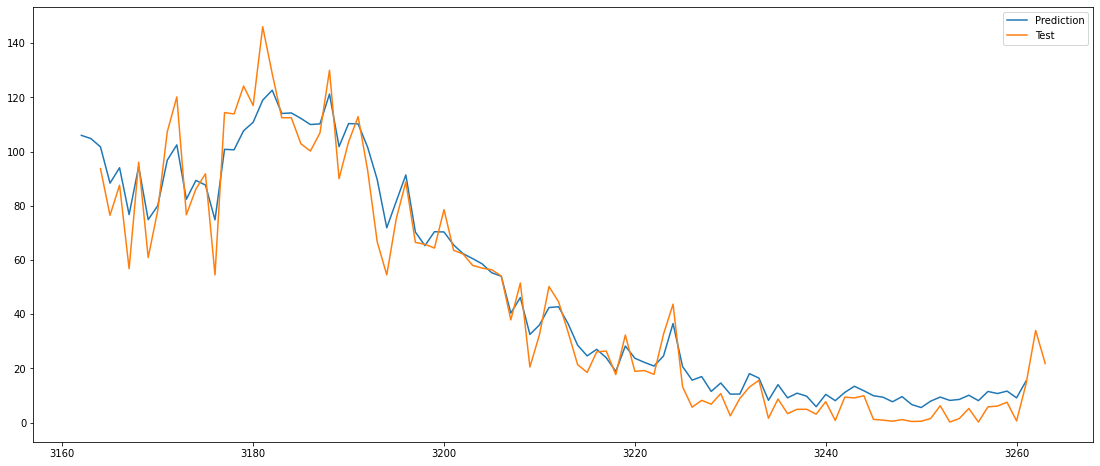

In [122]:
print(X_train)
prediction=[]
from sklearn.linear_model import Lasso
# Modell fittelése
lassoreg = Lasso(alpha=0.001,normalize=True, max_iter=1e8)
lassoreg.fit(X_train,y_train)

prediction=lassoreg.predict(X_test)

predictions = pd.Series(prediction)

predictions.index =test_data.index[sample-2:-2]

fig, ax = plt.subplots(figsize=(19,8))
plt.plot(predictions[-100:], label="Prediction")

#plt.plot(train_data[3][-100:], label="Train")

plt.plot(test_data[3][-100:], label="Test")
plt.legend()
plt.show()



## Opcionális feladat: Napi modellezés

Kisérleje meg általánosítani a fenti eljárást a napi adatokon!